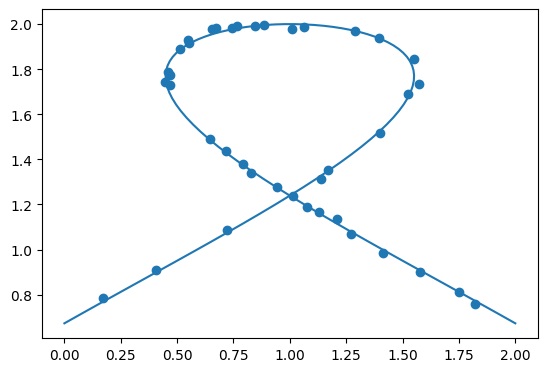

In [6]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
timesteps = 100

times = jnp.linspace(0, 1, timesteps)
x_positions = jnp.sin(times * 2 * jnp.pi) + 2 * times
y_positions = jnp.exp(-((0.5 + -times) ** 2)) * 6 - 4

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.plot(x_positions, y_positions, label="True trajectory")
samples = (
    jnp.stack([x_positions, y_positions], axis=1)
    + jax.random.normal(jax.random.PRNGKey(0), (timesteps, 2)) * 0.01
)

n_samples = 40
samples_idx = jax.random.permutation(jax.random.PRNGKey(2), jnp.arange(timesteps))[
    :n_samples
]

ax.scatter(
    samples[samples_idx][:, 0],
    samples[samples_idx][:, 1],
    label="Subsampled observations",
)
# convert to mask

mask = jnp.ones(timesteps).astype(bool)
mask = mask.at[samples_idx].set(True)
mask = mask.at[::3].set(True)
mask = mask.at[0].set(False)
mask = mask.at[-2].set(True)
mask = mask.at[-1].set(True)

Running q = 0
<function fit_trajectory_samples.<locals>.obs at 0x32ab66e50>
state size: 2
taylor add h (2, 2)
made it to kalman filter again
state_size 2
prior mean (2,)
prior cholvariance (2, 2)
chol obs (2, 2)
Running q = 1
<function fit_trajectory_samples.<locals>.obs at 0x32aba1d30>
state size: 2
taylor add h (4, 4)
made it to kalman filter again
state_size 2
prior mean (4,)
prior cholvariance (4, 4)
chol obs (2, 2)
Running q = 2
<function fit_trajectory_samples.<locals>.obs at 0x32abd8c10>
state size: 2
taylor add h (6, 6)
made it to kalman filter again
state_size 2
prior mean (6,)
prior cholvariance (6, 6)
chol obs (2, 2)
Running q = 3
<function fit_trajectory_samples.<locals>.obs at 0x32adbf8b0>
state size: 2
taylor add h (8, 8)
made it to kalman filter again
state_size 2
prior mean (8,)
prior cholvariance (8, 8)
chol obs (2, 2)
Running q = 4
<function fit_trajectory_samples.<locals>.obs at 0x3274eed30>
state size: 2
taylor add h (10, 10)
made it to kalman filter again
state_siz

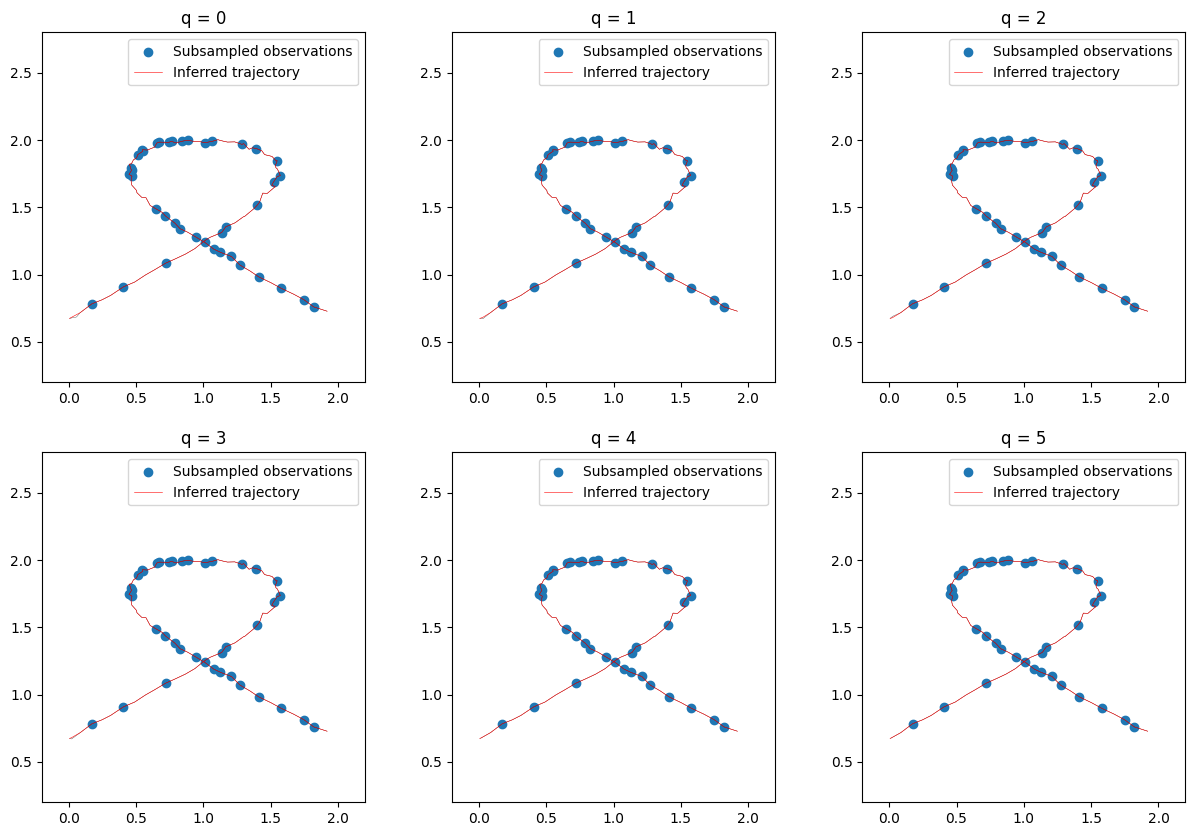

In [8]:
from probabilistic_numerics import kalman_filter as pn


def fit_trajectory_samples(q, ax):
    state = 2
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[:2].set(samples[0])
    delta = 1 / (timesteps - 1)

    def obs(state, time, step):
        sample = samples[step]
        return state[:2] - sample

    samples_, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=-jnp.eye(state),
        initial_mean=initial_mean,
        initial_cov_diag=jnp.zeros_like(initial_mean),
        derivatives=q,
        n_solution_points=timesteps,
        delta_time=delta,
        prior_type="heat",
        observation_function=obs,
        update_indicator=mask,
        observation_uncertainty=jnp.eye(state) * 0,
        n_samples=1,
    )
    for i in range(jnp.size(samples_, axis=1)):
        ax.plot(
            samples_[:, i, 0],
            samples_[:, i, 1],
            # label="Inferred trajectory",
            color="k",
            linewidth=0.2,
        )
    ax.scatter(
        samples[samples_idx][:, 0],
        samples[samples_idx][:, 1],
        label="Subsampled observations",
    )
    ax.set_aspect("equal")
    ax.plot(
        means[:, 0],
        means[:, 1],
        label="Inferred trajectory",
        color="r",
        linewidth=0.4,
    )

    ax.set_xlim(-0.2, 2.2)
    ax.set_ylim(0.2, 2.8)
    ax.legend()


qs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9][:6]
width = int(jnp.ceil(jnp.sqrt(len(qs))))
height = int(jnp.ceil(len(qs) / width))
fig, ax = plt.subplots(height, width, figsize=(5 * width, 5 * height))
for q, ax in zip(qs, ax.flatten()):
    print(f"Running q = {q}")
    ax.set_title(f"q = {q}")
    fit_trajectory_samples(q, ax)

Running q = 2, prior = iwp, evals = 50
<function pn_solve_nonlinear_IVP.<locals>.zero_obs at 0x32f4cbf70>
state size: 1
taylor add h (3, 3)
made it to kalman filter again
state_size 1
prior mean (3,)
prior cholvariance (3, 3)
chol obs (1, 1)
Running q = 3, prior = iwp, evals = 50
<function pn_solve_nonlinear_IVP.<locals>.zero_obs at 0x32ad459d0>
state size: 1
taylor add h (4, 4)
made it to kalman filter again
state_size 1
prior mean (4,)
prior cholvariance (4, 4)
chol obs (1, 1)
Running q = 4, prior = iwp, evals = 50
<function pn_solve_nonlinear_IVP.<locals>.zero_obs at 0x33cee7160>
state size: 1
taylor add h (5, 5)
made it to kalman filter again
state_size 1
prior mean (5,)
prior cholvariance (5, 5)
chol obs (1, 1)
Running q = 5, prior = iwp, evals = 50
<function pn_solve_nonlinear_IVP.<locals>.zero_obs at 0x32ac92a60>
state size: 1
taylor add h (6, 6)
made it to kalman filter again
state_size 1
prior mean (6,)
prior cholvariance (6, 6)
chol obs (1, 1)
Running q = 6, prior = iwp, eval

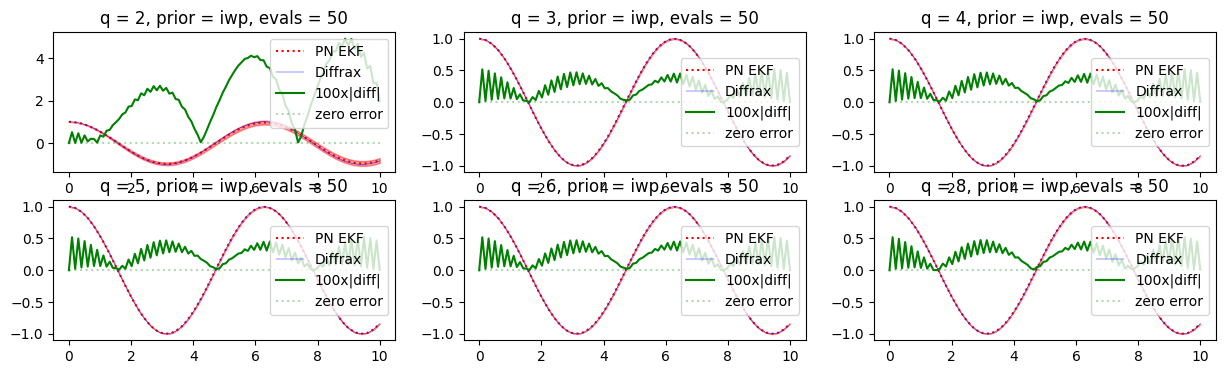

In [10]:
from probabilistic_numerics import kalman_filter as pn
from diffrax import diffeqsolve, ODETerm, SaveAt, PIDController, Kvaerno5
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)


def vector_field(_t, state, _args):
    x, x_ = state
    return jnp.array([x_, -x])


end_time = 10
# Define the ODE term
term = ODETerm(vector_field)
solver = Kvaerno5()
saveat = SaveAt(ts=jnp.linspace(0, end_time, 100, endpoint=True))
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)

# Solve the system
diffrax_sol = diffeqsolve(
    term,
    solver,
    t0=0,
    t1=end_time + 0.1,
    dt0=0.01,
    y0=jnp.array([1.0, 0.0]),
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=50000,
).ys[:, 0]


def pn_solve_nonlinear_IVP(q, ax, n_solution_points, prior_name, prior_matrix):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[0].set(1.0)
    initial_mean = initial_mean.at[2].set(-1.0)

    delta = end_time / (n_solution_points - 1)

    def zero_obs(state, time, step):
        return jnp.array([state[0] + state[2]])

    _samples, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=prior_matrix,
        initial_mean=initial_mean,
        initial_cov_diag=jnp.zeros_like(initial_mean),
        derivatives=q,
        n_solution_points=n_solution_points,
        delta_time=delta,
        prior_type=prior_name,
        observation_function=zero_obs,
        update_indicator=jnp.ones(n_solution_points),
        observation_uncertainty=jnp.eye(1) * 0,
        n_samples=0,
    )

    x_axis = jnp.linspace(0, end_time, 100)
    means = jnp.interp(
        x_axis,
        jnp.linspace(0, end_time, n_solution_points, endpoint=True),
        means[:, 0],
    )
    stds = jnp.interp(
        x_axis, jnp.linspace(0, end_time, n_solution_points, endpoint=True), stds[:, 0]
    )
    ax.plot(
        x_axis,
        means,
        label="PN EKF",
        linestyle="dotted",
        color="r",
    )
    ax.fill_between(
        x_axis,
        means - stds * 3,
        means + stds * 3,
        alpha=0.4,
        color="r",
    )
    ax.plot(
        x_axis,
        diffrax_sol,
        label="Diffrax",
        color="b",
        linewidth=0.3,
    )
    ax.plot(x_axis, 100 * jnp.abs(means - diffrax_sol), label="100x|diff|", color="g")
    ax.plot(
        x_axis, 100 * [0], label="zero error", color="g", linestyle="dotted", alpha=0.3
    )

    ax.legend()
    # ax.set_ylim(-10, 10)
    # ax.axis("off")

    return means, stds


qs = [
    2,
    3,
    4,
    5,
    6,
    8,
]
priors = [
    ("iwp", jnp.zeros((1, 1))),
    # ("wave", -jnp.eye(1)),
]
evaluation_counts = jnp.linspace(50, 1000, 3)[:1]
import itertools

amount = len(qs) * len(priors) * len(evaluation_counts)
width = int(jnp.ceil(jnp.sqrt(amount)))
height = int(jnp.ceil(amount / width))
fig, ax = plt.subplots(height, width, figsize=(5 * width, 2 * height))

results = []

for (q, (prior_name, prior_matrix), timesteps), ax in zip(
    itertools.product(qs, priors, evaluation_counts), ax.flatten()
):
    print(f"Running q = {q}, prior = {prior_name}, evals = {int(timesteps)}")
    ax.set_title(f"q = {q}, prior = {prior_name}, evals = {int(timesteps)}")
    means, stds = pn_solve_nonlinear_IVP(
        q, ax, int(timesteps), prior_name, prior_matrix
    )
    results += [(q, prior_name, int(timesteps), means, stds)]

<function pn_solve_nonlinear_IVP.<locals>.zero_obs at 0x34bcdd550>
state size: 1
taylor add h (3, 3)
made it to kalman filter again
state_size 1
prior mean (3,)
prior cholvariance (3, 3)
chol obs (1,)
<function pn_solve_nonlinear_IVP.<locals>.zero_obs at 0x34c208430>
state size: 1
taylor add h (3, 3)
made it to kalman filter again
state_size 1
prior mean (3,)
prior cholvariance (3, 3)
chol obs (1,)
<function pn_solve_nonlinear_IVP.<locals>.zero_obs at 0x34c22e310>
state size: 1
taylor add h (3, 3)
made it to kalman filter again
state_size 1
prior mean (3,)
prior cholvariance (3, 3)
chol obs (1,)
<function pn_solve_nonlinear_IVP.<locals>.zero_obs at 0x34c2671f0>
state size: 1
taylor add h (3, 3)
made it to kalman filter again
state_size 1
prior mean (3,)
prior cholvariance (3, 3)
chol obs (1,)
<function pn_solve_nonlinear_IVP.<locals>.zero_obs at 0x34c29d0d0>
state size: 1
taylor add h (4, 4)
made it to kalman filter again
state_size 1
prior mean (4,)
prior cholvariance (4, 4)
chol obs 

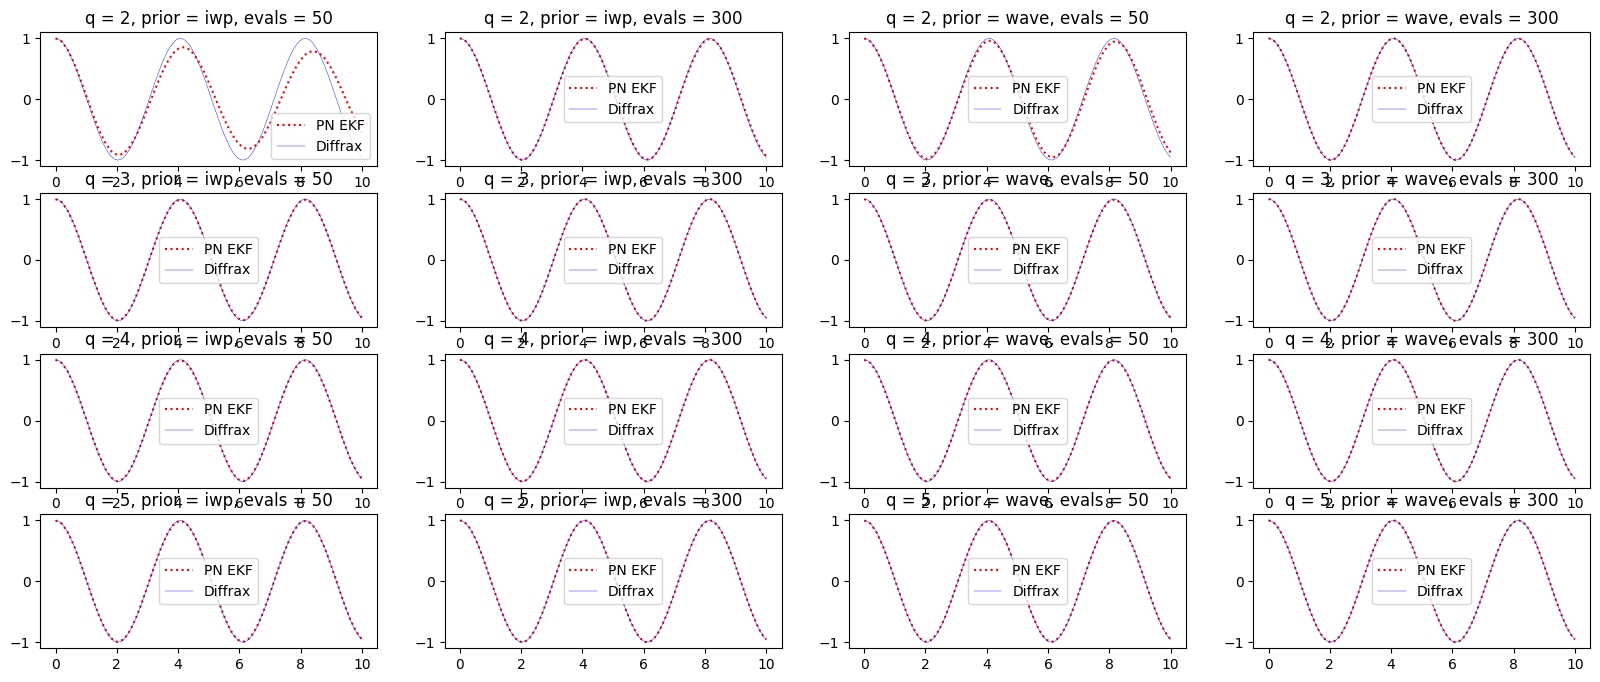

In [12]:
from probabilistic_numerics import kalman_filter as pn
from diffrax import diffeqsolve, ODETerm, SaveAt, PIDController, Kvaerno5
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)


def tan(x):
    return jnp.sin(x) / jnp.cos(x)


def vector_field(_t, state, _args):
    x, x_ = state
    return jnp.array([x_, -x + -tan(x)])


end_time = 10
# Define the ODE term
term = ODETerm(vector_field)
solver = Kvaerno5()
saveat = SaveAt(ts=jnp.linspace(0, end_time, 100, endpoint=True))
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)

# Solve the system
diffrax_sol = diffeqsolve(
    term,
    solver,
    t0=0,
    t1=end_time + 0.1,
    dt0=0.01,
    y0=jnp.array([1.0, 0.0]),
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=50000,
).ys[:, 0]

import probdiffeq.taylor as taylor
import jax
import jax.numpy as jnp


def pn_solve_nonlinear_IVP(q, ax, n_solution_points, prior_name, prior_matrix):
    assert 2 * (n_solution_points // 2) == n_solution_points
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[0].set(1.0)

    tcoeffs = taylor.odejet_padded_scan(
        lambda y, dy: -y - tan(y), (initial_mean[0], initial_mean[1]), num=q - 1
    )
    initial_mean = jnp.array(tcoeffs).flatten()

    delta = end_time / (n_solution_points - 1)

    def zero_obs(state, time, step):
        return jnp.array([+state[0] + tan(state[0]) + state[2]])

    _samples, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=prior_matrix,
        initial_mean=initial_mean,
        initial_cov_diag=jnp.zeros_like(initial_mean),
        derivatives=q,
        n_solution_points=n_solution_points,
        delta_time=delta,
        prior_type=prior_name,
        observation_function=zero_obs,
        update_indicator=jnp.ones(n_solution_points),
        # update_indicator=jnp.asarray(
        #     [True] * ((n_solution_points) // 2) + [False] * ((n_solution_points) // 2)
        # ),
        observation_uncertainty=jnp.zeros(1),
        n_samples=0,
    )

    x_axis = jnp.linspace(0, end_time, 100)
    means = jnp.interp(
        x_axis,
        jnp.linspace(0, end_time, n_solution_points, endpoint=True),
        means[:, 0],
    )
    stds = jnp.interp(
        x_axis, jnp.linspace(0, end_time, n_solution_points, endpoint=True), stds[:, 0]
    )
    ax.plot(
        x_axis,
        means,
        label="PN EKF",
        linestyle="dotted",
        color="r",
    )
    # ax.fill_between(
    #     x_axis,
    #     means - stds * 3,
    #     means + stds * 3,
    #     alpha=0.4,
    #     color="r",
    # )
    ax.plot(
        x_axis,
        diffrax_sol,
        label="Diffrax",
        color="b",
        linewidth=0.3,
    )
    # ax.plot(x_axis, 100 * jnp.abs(means - diffrax_sol), label="100x|diff|", color="g")
    # ax.plot(
    #     x_axis, 100 * [0], label="zero error", color="g", linestyle="dotted", alpha=0.3
    # )

    ax.legend()
    # ax.set_ylim(-10, 10)
    # ax.axis("off")

    return means, stds


qs = [
    2,
    3,
    4,
    5,
    6,
    8,
][:4]
priors = [
    ("iwp", jnp.zeros((1, 1))),
    ("wave", -2 * jnp.eye(1)),
]
evaluation_counts = jnp.linspace(50, 300, 2)
import itertools

amount = len(qs) * len(priors) * len(evaluation_counts)
width = int(jnp.ceil(jnp.sqrt(amount)))
height = int(jnp.ceil(amount / width))
fig, ax = plt.subplots(height, width, figsize=(5 * width, 2 * height))

results = []

for (q, (prior_name, prior_matrix), timesteps), ax in zip(
    itertools.product(qs, priors, evaluation_counts), ax.flatten()
):
    # print(f"Running q = {q}, prior = {prior_name}, evals = {int(timesteps)}")
    ax.set_title(f"q = {q}, prior = {prior_name}, evals = {int(timesteps)}")
    means, stds = pn_solve_nonlinear_IVP(
        q, ax, int(timesteps), prior_name, prior_matrix
    )
    results += [(q, prior_name, int(timesteps), means, stds)]

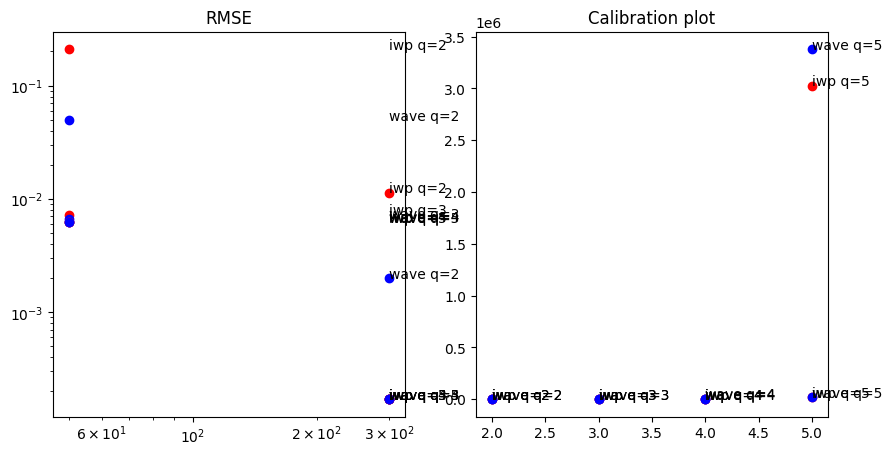

In [ ]:
fig, (rmseplot, calibration_plot) = plt.subplots(1, 2, figsize=(10, 5))
rmseplot.set_title("RMSE")
rmseplot.loglog()
calibration_plot.set_title("Calibration plot")

for q, prior_name, n_solution_points, means, stds in results:
    rmse = jnp.sqrt(jnp.mean((means[1:] - diffrax_sol[1:]) ** 2))
    rmseplot.plot(
        n_solution_points,
        rmse,
        "o",
        label=f"{prior_name}",
        color="r" if prior_name == "iwp" else "b",
    )
    rmseplot.text(timesteps, rmse, f"{prior_name} q={q}")

    calibration = jnp.mean(((means[1:] - diffrax_sol[1:]) / stds[1:]) ** 2) / 99
    calibration_plot.plot(
        q,
        calibration,
        "o",
        label=f"{prior_name}",
        color="r" if prior_name == "iwp" else "b",
    )
    calibration_plot.text(q, calibration, f"{prior_name} q={q}")